### Mask-RCNN inference with tensorflow, onnxruntime, TensorRT engine.  Balloon dataset

In [1]:
import os
os.chdir('..')

In [2]:
import subprocess
import cv2
import numpy as np

import matplotlib.pyplot as plt

from layers import losses
from training import get_optimizer
from model import mask_rcnn_functional
from common import inference_utils
from common.inference_utils import process_input
from common import utils
from common.config import CONFIG

import tensorflow as tf
utils.tf_limit_gpu_memory(tf, 1500)

Physical GPU-devices: []


In [ ]:
%load_ext watermark
%watermark
%watermark --iversions

#### Prepare model for inference

In [3]:
weights_path= r"/home/user/MaskTests/maskrcnn_tf2/result_models/512x512/maskrcnn_mobilenet_c1f61e61570ae80cd3c574c008cbf226_cp-0010.ckpt"
# weights_path = r'D:\Source\maskrcnn_tf2\src\result_models\256x256\maskrcnn_mobilenet_c7d9053b6f41759350d0161adec43865_cp-0002.ckpt'
# weights_path = r'D:\Source\maskrcnn_tf2\src\result_models\512x512\maskrcnn_mobilenet_c1f61e61570ae80cd3c574c008cbf226_cp-0010.ckpt'
weights_path

'/home/user/MaskTests/maskrcnn_tf2/result_models/512x512/maskrcnn_mobilenet_c1f61e61570ae80cd3c574c008cbf226_cp-0010.ckpt'

In [7]:
from samples.plates import plates
CONFIG.update(plates.COCO_CONFIG)

# CONFIG.update({
#                 'image_shape': (256, 256, 3),
#                 'image_resize_mode': 'square',
#                 'img_size': 256,
#                 'image_min_dim': 200,
#                 'image_min_scale': 0,
#                 'image_max_dim': 256,
#                 'batch_size': 1,
#                 'images_per_gpu': 1,

#                 }
#     )


In [ ]:
# Loading inference graph and import weights
from samples.plates import plates
# CONFIG.update(plates.COCO_CONFIG)


inference_config = CONFIG
inference_config.update({'training': False})
inference_model = mask_rcnn_functional(config=inference_config)
inference_model = inference_utils.load_mrcnn_weights(model=inference_model,
                                                     weights_path=weights_path,
                                                     verbose=True
                                                    )

---

#### Run several tests with tensorflow

In [ ]:
test_images_path = r'/home/user/test_tlt/data/raw-data/imgtest'
os.listdir(test_images_path)

In [6]:
import time

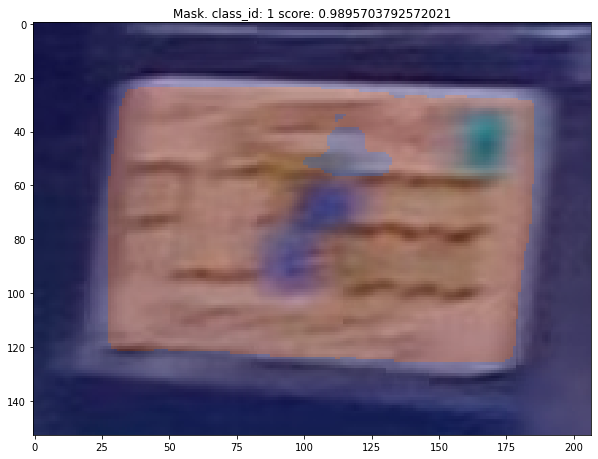

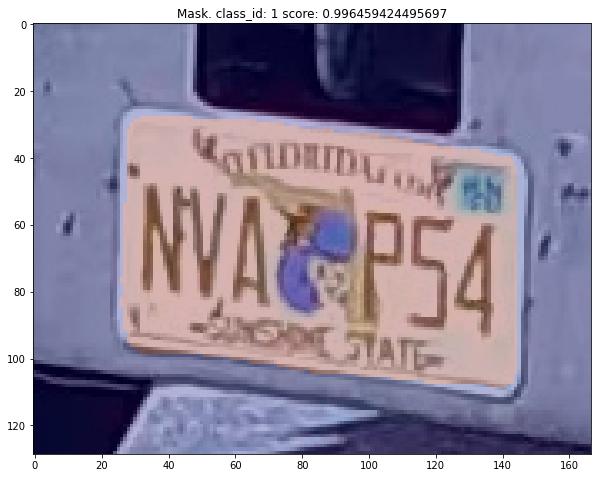

In [7]:
for img_name in os.listdir(test_images_path)[:2]:
    img = cv2.imread(os.path.join(test_images_path, img_name))
    img_processed, image_meta, window = process_input(img, CONFIG)
    
    output = inference_model([np.expand_dims(img_processed, 0),
                              np.expand_dims(image_meta, 0)]
                            ) 
    
    detections, mrcnn_probs, mrcnn_bbox, mrcnn_mask, rpn_rois, rpn_class, rpn_bbox = output
    
    # print(img_name, '\nOutput shapes:')
    # for out in output:
    #     print(out.shape)
    
    
    # Extract bboxes, class_ids, scores and full-size masks
    boxes, class_ids, scores, full_masks = \
    utils.reformat_detections(detections=detections[0].numpy(), 
                              mrcnn_mask=mrcnn_mask[0].numpy(), 
                              original_image_shape=img.shape, 
                              image_shape=img_processed.shape, 
                              window=window
                             )
    
    fig=plt.figure(figsize=(10,10))
    plt.title('Input data')

    plt.imshow(img, 'gray', interpolation='none')
    out_data = zip(class_ids, scores, np.moveaxis(full_masks, -1, 0))
    out_data = sorted(filter(lambda x: x[1]>=.9,out_data), key=lambda y: y[1], reverse=True)
    # data= next(out_data)
    # if data is None or not any(data):
    #     continue
    c, s, fm = out_data[0]

    plt.imshow(fm, 'jet', interpolation='none', alpha=0.3)
    plt.title(f'Mask. class_id: {c} score: {s}')
    plt.show()    
    # for c, s, fm in zip(class_ids, scores, np.moveaxis(full_masks, -1, 0)):

    #     fig=plt.figure(figsize=(5,5))
    #     plt.title(f'Mask. class_id: {c} score: {s}')
    #     plt.imshow(fm)
    plt.show()    

#### Convert model to .onnx with tf2onnx

In [9]:
import tf2onnx
import onnx
import onnxruntime as ort

def maskrcnn_to_onnx(model, model_name, input_spec, kwargs):
    if model.name != 'mask_rcnn_inference':
        raise ValueError('Inference model should be send to maskrcnn_to_onnx function.')

    output_path = f'../weights/{model_name}.onnx'
    _, _ = tf2onnx.convert.from_keras(model=model,
                                      input_signature=input_spec,
                                      output_path=output_path,
                                      **kwargs)
    print(f'Successfully converted from tensorflow to .onnx: {output_path}')
# import onnx_graphsurgeon as gs


In [10]:
input_spec = (
    tf.TensorSpec((CONFIG['batch_size'], *CONFIG['image_shape']), tf.float32, name="input_image"),
    tf.TensorSpec((CONFIG['batch_size'], CONFIG['meta_shape']), tf.float32, name="input_image_meta")
)
model_name = f"""maskrcnn_{CONFIG['backbone']}_{'_'.join(list(map(str, CONFIG['image_shape'])))}""" 

In [ ]:
maskrcnn_to_onnx(model=inference_model, 
                 model_name = model_name,
                 input_spec=input_spec,
                 kwargs={'opset': 11}
                )

#### Load onnx model and check it 

In [9]:
import tf2onnx
import onnx
import onnxruntime as ort

In [ ]:
# Load the ONNX model
model = onnx.load(f"""../weights/maskrcnn_{CONFIG['backbone']}_512_512_3.onnx""")
# Check that the IR is well formed
onnx.checker.check_model(model)
# Print a human readable representation of the graph
print(onnx.helper.printable_graph(model.graph))

#### Run several tests with onnxruntime

In [11]:
sess = ort.InferenceSession(f"""../weights/maskrcnn_{CONFIG['backbone']}_512_512_3.onnx""")
print(f'Inputs: {[x.name for x in sess.get_inputs()]}\nOutputs:{[x.name for x in sess.get_outputs()]}')

Inputs: ['input_image', 'input_image_meta']
Outputs:['mrcnn_detection', 'fpnclf_mrcnn_class', 'fpnclf_mrcnn_bbox_reshape', 'mrcnn_mask', 'roi', 'concat_rpn_class', 'concat_rpn_bbox']


In [ ]:
for img_name in os.listdir(test_images_path)[:2]:
    img = cv2.imread(os.path.join(test_images_path, img_name))
    img_processed, image_meta, window = process_input(img, CONFIG)
    

    output = sess.run(output_names=[x.name for x in sess.get_outputs()], 
                      input_feed={'input_image': np.expand_dims(img_processed, 0).astype('float32'),
                                  'input_image_meta': np.expand_dims(image_meta, 0).astype('float32'),
                                 }
                     )
    
    detections, mrcnn_probs, mrcnn_bbox, mrcnn_mask, rpn_rois, rpn_class, rpn_bbox = output
    
    print(img_name, '\nOutput shapes:')
    for out in output:
        print(out.shape)
    
    
    # Extract bboxes, class_ids, scores and full-size masks
    boxes, class_ids, scores, full_masks = \
    utils.reformat_detections(detections=detections[0], 
                              mrcnn_mask=mrcnn_mask[0], 
                              original_image_shape=img.shape, 
                              image_shape=img_processed.shape, 
                              window=window
                             )
    
    fig=plt.figure(figsize=(10,10))
    plt.title('Input data')

    plt.imshow(img, 'gray', interpolation='none')
    out_data = zip(class_ids, scores, np.moveaxis(full_masks, -1, 0))
    out_data = sorted(filter(lambda x: x[1]>=.9,out_data), key=lambda y: y[1], reverse=True)
    # data= next(out_data)
    # if data is None or not any(data):
    #     continue
    c, s, fm = out_data[0]

    plt.imshow(fm, 'jet', interpolation='none', alpha=0.3)
    plt.title(f'Mask. class_id: {c} score: {s}')
    plt.show() 

#### Configure model for TensorRT

In [ ]:
from common.inference_optimize import maskrcnn_to_onnx, modify_onnx_model

In [12]:
modify_onnx_model(model_path=f'../weights/{model_name}.onnx',
                  config=CONFIG,
                  verbose=True
                 )

NameError: name 'modify_onnx_model' is not defined

#### TensorRT optimization

__With trtexec:__ 

In [ ]:
%%time

os.chdir('../weights')

# Construct appropriate command
fp16_mode = False
command = [os.environ['TRTEXEC'],
           f'--onnx={model_name}_trt_mod.onnx',
           f'--saveEngine={model_name}_trt_mod_fp32.engine',
            '--workspace=2048',
            '--explicitBatch',
            '--verbose',
          ]

# fp16 param
if fp16_mode:
    command[2].replace('32', '16')
    command.append('--fp16')

# tacticSources param
# Do not neeed on jetson with aarch64 architecture for now.
arch = os.uname().machine
if arch == 'x86_64':
    command.append('--tacticSources=-cublasLt,+cublas')
    
print(f'\nArch: {arch}\ntrtexec command list: {command}')

result = subprocess.run(command, capture_output=True, check=True)
# Print stdout inference result
print(result.stdout.decode('utf8')[-2495:])

__With python TensorRT API:__


In [ ]:
import tensorrt as trt
import pycuda.autoinit
import pycuda.driver as cuda

In [ ]:
max_batch_size = 1
# Precision mode
fp16_mode = False
# Workspace size in Mb
wspace_size = 2048

In [ ]:
%%time

# Init TensorRT Logger
TRT_LOGGER = trt.Logger(trt.Logger.VERBOSE)
# Init TensorRT plugins
trt.init_libnvinfer_plugins(TRT_LOGGER, "")
# Set tensorrt-prepared onnx model
onnx_model_path = f'../weights/{model_name}_trt_mod.onnx'
# Use explicit batch
explicit_batch = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)

with trt.Builder(TRT_LOGGER) as builder, \
        builder.create_builder_config() as builder_config, \
        builder.create_network(explicit_batch) as network, \
        trt.OnnxParser(network, TRT_LOGGER) as parser:

    with open(onnx_model_path, 'rb') as model:
        parser.parse(model.read())

    print('Num of detected layers: ', network.num_layers)
    print('Detected inputs: ', network.num_inputs)
    print('Detected outputs: ', network.num_outputs)
    
    # Workspace size
    # 1e6 bytes == 1Mb
    builder_config.max_workspace_size = int(1e6 * wspace_size)
    
    # Precision mode
    if fp16_mode:
        builder_config.set_flag(trt.BuilderFlag.FP16)
    
    # Max batch size
    builder.max_batch_size = max_batch_size
    
    # Set the list of tactic sources
    # Do not need for Jetson with aarch64 architecture for now
    arch = os.uname().machine
    if arch == 'x86_64':
        tactic_source = 1 << int(trt.TacticSource.CUBLAS) | 0 << int(trt.TacticSource.CUBLAS_LT)
        builder_config.set_tactic_sources(tactic_source)
        
    
    # Make TensorRT engine
    engine = builder.build_engine(network, builder_config)
    
    # Save TensorRT engine
    if fp16_mode:
        trt_model_name = f'../weights/{model_name}_fp16_trt.engine'
    else:
        trt_model_name = f'../weights/{model_name}_fp32_trt.engine'

    with open(trt_model_name, "wb") as f:
        f.write(engine.serialize())

#### Run TensorRT inference

In [ ]:
def trt_mrcnn_inference(model, image):
    """

    Args:
        model: tensorflow tf.keras.Model
        image: prepared image for inference

    Returns: boxes,
             class_ids, 
             scores, f
             ull_masks, 
             eval_gt_boxes, 
             eval_gt_class_ids, 
             eval_gt_masks

    """

    # Extract trt-variables from a dict for transparency
    engine = model['engine']
    stream = model['stream']
    context = model['context']
    device_input = model['device_input']
    device_output1 = model['device_output1']
    device_output2 = model['device_output2']

    host_output1 = model['host_output1']
    host_output2 = model['host_output2']

    # Make inference
    host_input = image.astype(dtype=np.float32, order='C')
    cuda.memcpy_htod_async(device_input, host_input, stream)
    context.execute_async(bindings=[int(device_input),
                                    int(device_output1),
                                    int(device_output2),
                                    ],
                          stream_handle=stream.handle)

    cuda.memcpy_dtoh_async(host_output1, device_output1, stream)
    cuda.memcpy_dtoh_async(host_output2, device_output2, stream)
    stream.synchronize()
    
    trt_mrcnn_detection = host_output1.reshape(
        engine.get_binding_shape('mrcnn_detection')).astype(dtype=np.float32)
    trt_mrcnn_mask = host_output2.reshape(
        engine.get_binding_shape('mrcnn_mask')).astype(dtype=np.float32)
    
    return trt_mrcnn_detection, trt_mrcnn_mask

In [ ]:
def set_mrcnn_trt_engine(model_path):
    
    """
    Load TensorRT engine via pycuda
    Args:
        model_path: model path to TensorRT-engine

    Returns: python dict of attributes for pycuda model inference

    """
    
    trt_logger = trt.Logger(trt.Logger.VERBOSE)
    trt.init_libnvinfer_plugins(trt_logger, "")

    with open(model_path, "rb") as f, trt.Runtime(trt_logger) as runtime:
        engine = runtime.deserialize_cuda_engine(f.read())
    context = engine.create_execution_context()

    # Inputs
    input_shape = engine.get_binding_shape('input_image')
    input_size = trt.volume(input_shape) *\
                 engine.max_batch_size * np.dtype(np.float32).itemsize
    device_input = cuda.mem_alloc(input_size)

    # Outputs
    output_names = list(engine)[1:]

    # mrcnn_detection output
    output_shape1 = engine.get_binding_shape('mrcnn_detection')
    host_output1 = cuda.pagelocked_empty(trt.volume(output_shape1) *
                                              engine.max_batch_size,
                                              dtype=np.float32)
    device_output1 = cuda.mem_alloc(host_output1.nbytes)


    # mrcnn_mask output
    output_shape2 = engine.get_binding_shape('mrcnn_mask')
    host_output2 = cuda.pagelocked_empty(trt.volume(output_shape2) * engine.max_batch_size,
                                              dtype=np.float32)
    device_output2 = cuda.mem_alloc(host_output2.nbytes)

    # Setting a cuda stream
    stream = cuda.Stream()
    
    return {'engine': engine,
            'stream': stream,
            'context': context,
            'device_input': device_input,
            'device_output1': device_output1,
            'device_output2':device_output2,
            'host_output1': host_output1,
            'host_output2': host_output2
           }

In [ ]:
trt_model = set_mrcnn_trt_engine(f"""../weights/maskrcnn_{CONFIG['backbone']}_512_512_3_trt_mod_fp32.engine""")

In [ ]:
for img_name in os.listdir(test_images_path):
    img = cv2.imread(os.path.join(test_images_path, img_name))
    img_processed, image_meta, window = process_input(img, CONFIG)
    

    trt_mrcnn_detection, trt_mrcnn_mask = trt_mrcnn_inference(trt_model, np.expand_dims(img_processed, 0))
    

    # Extract bboxes, class_ids, scores and full-size masks
    boxes, class_ids, scores, full_masks = \
    utils.reformat_detections(detections=trt_mrcnn_detection[0], 
                              mrcnn_mask=trt_mrcnn_mask[0], 
                              original_image_shape=img.shape, 
                              image_shape=img_processed.shape, 
                              window=window
                             )
    
    fig=plt.figure(figsize=(10,10))
    plt.title('Input data')
    plt.imshow(img)

    for c, s, fm in zip(class_ids, scores, np.moveaxis(full_masks, -1, 0)):

        fig=plt.figure(figsize=(5,5))
        plt.title(f'Mask. class_id: {c} score: {s}')
        plt.imshow(fm)